In [1]:
import transformers
from datasets import Dataset
import evaluate

import pandas as pd
import torch
import logging
import glob
import os

from sklearn.metrics import accuracy_score, precision_recall_fscore_support

/home/mp/anaconda3/envs/mlops/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-03-17 17:59:44.212032: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-17 17:59:44.212063: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-17 17:59:44.212091: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-17 17:59:44.218393: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow b

In [2]:
df = pd.read_csv('data/processed/AITA-Reddit-Dataset.csv')

In [3]:
# get last created file
checkpoint = glob.glob(os.path.join('models/results','*'))
checkpoint.sort(key=os.path.getmtime)
chkpt = checkpoint[-1]

# chkpt = None

In [4]:
model_name = 'bert-base-uncased'

if chkpt is not None:
    model = transformers.BertForSequenceClassification.from_pretrained(chkpt, num_labels=4, problem_type='multi_label_classification').to('cuda')
else:
    model = transformers.BertForSequenceClassification.from_pretrained(model_name, num_labels=4, problem_type='multi_label_classification').to('cuda')

tokenizer = transformers.BertTokenizer.from_pretrained(model_name, problem_type='multi_label_classification')

In [5]:
classifier = transformers.pipeline('sentiment-analysis', model=model, tokenizer=tokenizer, device='cpu')

In [6]:
# Create Dataset
base_dataset = Dataset.from_pandas(df)

# Vectorize labels
cols = base_dataset.column_names
base_dataset = base_dataset.map(lambda x: {'labels': [x[c] for c in cols if c != "text"]})

/home/mp/anaconda3/envs/mlops/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


In [7]:
# Tokenize the data
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

# Tokenize the data (only keep relevant columns)
cols = base_dataset.column_names
cols.remove('labels')
dataset = base_dataset.select(range(1000)).map(tokenize_function, batched=True, remove_columns=cols)

In [8]:
# Create a dataset class with LABEL and TEXT columns
dataset = dataset.train_test_split(test_size=0.2)
validation_test_dataset = dataset['test'].train_test_split(test_size=0.5)
dataset['validation'] = validation_test_dataset['train']
dataset['test'] = validation_test_dataset['test']


In [9]:
# Model evaluation
f1 = evaluate.load('f1')

# logging.basicConfig(level=logging.INFO, filename='example.log')

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return f1.compute(predictions=predictions, references=labels)

In [ ]:
# finetune the model
training_args = transformers.TrainingArguments(
    output_dir='./models/results',          # output directory
    num_train_epochs=20,              # total number of training epochs
    per_device_train_batch_size=1,   # batch size per device during training
    per_device_eval_batch_size=1,    # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=100,
    evaluation_strategy='steps',
    eval_steps=500,
    save_steps=500,
)
trainer = transformers.Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset['train'],
    eval_dataset=dataset['validation'],
)
if chkpt is not None:
    trainer.train(chkpt)
else:
    trainer.train()
    

In [15]:
predictions = trainer.predict(dataset['test'])

In [16]:
predictions.predictions

array([[-10.165635 , -10.305018 ,   3.7571561,  -3.7540808],
       [-10.165506 , -10.304854 ,   3.7571688,  -3.7540278],
       [-10.164119 , -10.302999 ,   3.7574627,  -3.7536483],
       [-10.112638 , -10.257194 ,   3.7338185,  -3.7101927],
       [-10.165469 , -10.304749 ,   3.757206 ,  -3.7540965],
       [-10.165273 , -10.304448 ,   3.757265 ,  -3.7540126],
       [-10.165549 , -10.304887 ,   3.7571964,  -3.7540276],
       [-10.164414 , -10.303262 ,   3.7574744,  -3.7539556],
       [-10.165588 , -10.304883 ,   3.7572155,  -3.7541714],
       [-10.165154 , -10.304268 ,   3.75731  ,  -3.7540822],
       [-10.165353 , -10.304537 ,   3.757258 ,  -3.7541692],
       [-10.165474 , -10.304761 ,   3.7572117,  -3.7541194],
       [-10.165446 , -10.304763 ,   3.7572083,  -3.7540197],
       [-10.165656 , -10.305006 ,   3.7571692,  -3.7540948],
       [-10.165108 , -10.304249 ,   3.757269 ,  -3.7539046],
       [-10.165623 , -10.30498  ,   3.7571993,  -3.7541835],
       [-10.165496 , -10

In [17]:
predictions.label_ids.argmax(-1)    

array([2, 2, 2, 2, 2, 3, 3, 2, 2, 3, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 3,
       2, 3, 3, 2, 2, 3, 2, 2, 2, 3, 2, 2, 2, 2, 2, 3, 3, 2, 3, 2, 3, 2,
       3, 2, 2, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 3, 3, 3, 2, 2, 2, 3, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2])

In [18]:
predictions.label_ids.argmax(-1)

array([2, 2, 2, 2, 2, 3, 3, 2, 2, 3, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 3,
       2, 3, 3, 2, 2, 3, 2, 2, 2, 3, 2, 2, 2, 2, 2, 3, 3, 2, 3, 2, 3, 2,
       3, 2, 2, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 3, 3, 3, 2, 2, 2, 3, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2])

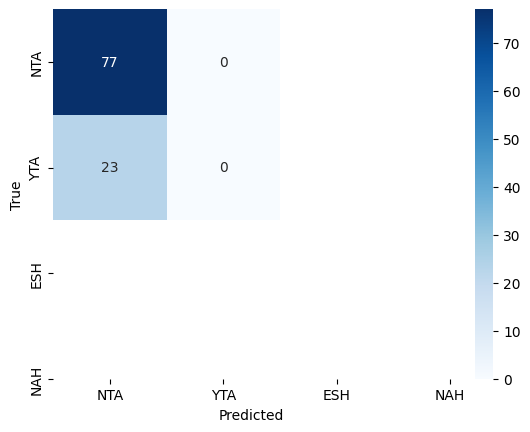

In [20]:
# sns confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np

cm = confusion_matrix(predictions.label_ids.argmax(-1), predictions.predictions.argmax(-1))

class_labels = ['NTA', 'YTA', 'ESH', 'NAH']

# cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()